<a href="https://colab.research.google.com/github/ba18406/Lab001/blob/master/Lab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4/dataset_Facebook.csv", delimiter = ";")

features = ["Category",
            "Page total likes",
            "Type",
            "Post Month",
            "Post Hour",
            "Post Weekday",
            "Paid"]


df[features].head()

,Category,Page total likes,Type,Post Month,Post Hour,Post Weekday,Paid
0,2,139441,Photo,12,3,4,0.0
1,2,139441,Status,12,10,3,0.0
2,3,139441,Photo,12,3,3,0.0
3,2,139441,Photo,12,10,2,1.0
4,2,139441,Photo,12,3,2,0.0


In [3]:
outcomes=  ["Lifetime Post Total Reach",
            "Lifetime Post Total Impressions",
            "Lifetime Engaged Users",
            "Lifetime Post Consumers",
            "Lifetime Post Consumptions",
            "Lifetime Post Impressions by people who have liked your Page",
            "Lifetime Post reach by people who like your Page",
            "Lifetime People who have liked your Page and engaged with your post",
            "comment",
            "like",
            "share",
            "Total Interactions"]

df[outcomes].head()

print(df[outcomes[-3:]].head().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    like &  share &  Total Interactions \\
\midrule
0 &    79.0 &   17.0 &                 100 \\
1 &   130.0 &   29.0 &                 164 \\
2 &    66.0 &   14.0 &                  80 \\
3 &  1572.0 &  147.0 &                1777 \\
4 &   325.0 &   49.0 &                 393 \\
\bottomrule
\end{tabular}



In [4]:
# convert a string variable to a categorical one
df[["Type"]] = df[["Type"]].apply(LabelEncoder().fit_transform)

df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,1,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,2,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,1,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,1,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,1,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [5]:
df = df.dropna()

outcomes_of_interest = ["Lifetime Post Consumers", "like"]
n_bins = 20

X_df = df[features].copy()
y_df = df[outcomes_of_interest].copy()

#print X_df.head().to_latex()

#print y_df.values
bins =  pd.qcut(y_df[outcomes_of_interest[0]].values,n_bins)

y_df = df[outcomes_of_interest].copy()
y_df[outcomes_of_interest[0]] = bins

y_df[outcomes_of_interest] = y_df[outcomes_of_interest].apply(LabelEncoder().fit_transform)

print(y_df.head())

   Lifetime Post Consumers  like
0                        0    73
1                       17   113
2                        0    61
3                       13   252
4                        6   205


In [6]:
X = X_df.values
y = y_df.values.T[0]

y_df['id'] = range(1, len(df) + 1)

y_df.head()

,Lifetime Post Consumers,like,id
0,0,73,1
1,17,113,2
2,0,61,3
3,13,252,4
4,6,205,5


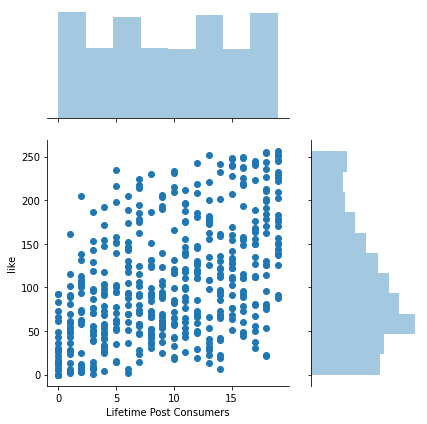

In [7]:
sns_plot = sns.jointplot(x="Lifetime Post Consumers", y="like", data=y_df, ratio = 2)

#sns_plot.savefig("joint_plot.png",bbox_inches='tight')
#sns_plot.savefig("joint_plot.pdf",bbox_inches='tight')

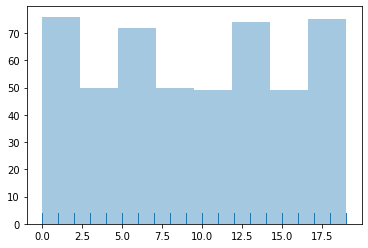

In [8]:
sns_plot = sns.distplot(y, kde=False, rug=True)

#sns_plot.savefig("histogram_lpc.png",bbox_inches='tight')
#sns_plot.savefig("histogram_lpc.pdf",bbox_inches='tight')

In [9]:
clf = ExtraTreesClassifier(n_estimators=1000, max_depth=4)

dummy_clf = DummyClassifier()
scores = cross_val_score(clf, X, y, cv=10,scoring = make_scorer(acc))

dummy_clf.fit(X,y)

print("ACC: %0.2f +/- %0.2f" % (scores.mean(), scores.std()))
print("Dummy ACC: %0.2f"% (acc(y,dummy_clf.predict(X))))

ACC: 0.15 +/- 0.05
Dummy ACC: 0.06


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [10]:
clf = ExtraTreesClassifier(n_estimators=20000, max_depth=4)
clf.fit(X,y)

print(acc(y,clf.predict(X)))

0.4121212121212121


[3 1 2 0 5 4 6]
Feature ranking:
1. Post Month (0.266144)
2. Page total likes (0.234599)
3. Type (0.207909)
4. Category (0.083941)
5. Post Weekday (0.072703)
6. Post Hour (0.070701)
7. Paid (0.064003)


(0.0, 0.44088288106925094)

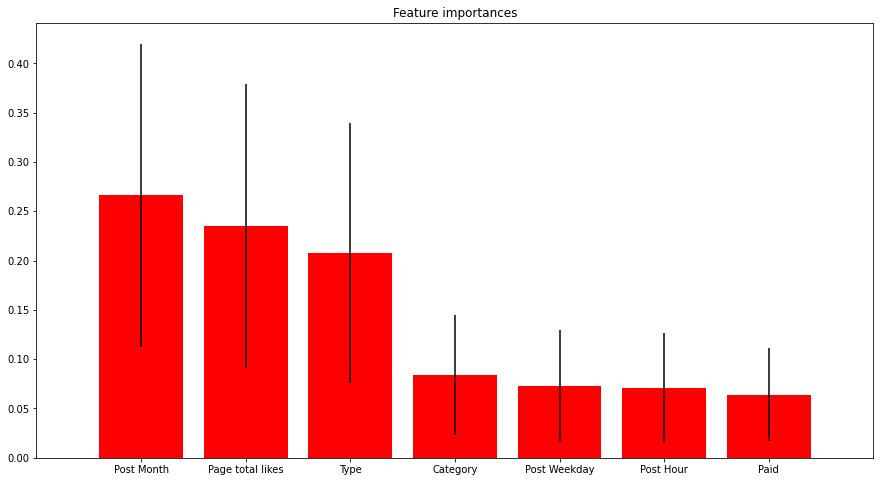

In [11]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices])
plt.xlim([-1, X.shape[1]])
fig.set_size_inches(15,8)
axes = plt.gca()
axes.set_ylim([0,None])

# plt.savefig("importances.png",bbox_inches='tight')
# plt.savefig("importances.pdf",bbox_inches='tight')

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        t = "(%.2f)"%(cm[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


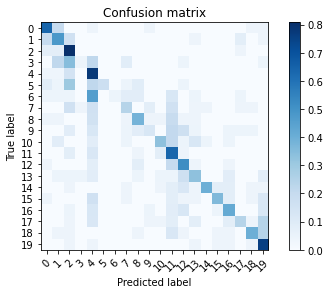

In [13]:
# Compute confusion matrix
y_pred = clf.predict(X)
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(len(set(y))), normalize = True,
                      title='Confusion matrix')

#plt.savefig("confusion.png",bbox_inches='tight')
#plt.savefig("confusion.pdf",bbox_inches='tight')

In [14]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4/dataset_Facebook.csv", delimiter = ";")
df
#print("The dataset has %d columns and %d rows" % (df.shape[1], df.shape[0]))

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,85093,Photo,3,1,7,2,0.0,4684,7536,733,708,985,4750,2876,392,5,53.0,26.0,84
496,81370,Photo,2,1,5,8,0.0,3480,6229,537,508,687,3961,2104,301,0,53.0,22.0,75
497,81370,Photo,1,1,5,2,0.0,3778,7216,625,572,795,4742,2388,363,4,93.0,18.0,115
498,81370,Photo,3,1,4,11,0.0,4156,7564,626,574,832,4534,2452,370,7,91.0,38.0,136


In [15]:
print(df.columns)

features = ["Category",
            "Page total likes",
            "Type",
            "Post Month",
            "Post Hour",
            "Post Weekday",
            "Paid"]


print(df[features].head())

Index(['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions'],
      dtype='object')
   Category  Page total likes    Type  ...  Post Hour  Post Weekday  Paid
0         2            139441   Photo  ...          3             4   0.0
1         2            139441  Status  ...         10             3   0.0
2         3            139441   Photo  ...          3             3   0.0
3         2            139441   Photo  ...         10             2   1.0
4         2            139441   Photo  ...          3             2   0.0

[

In [0]:
df = df.dropna()

In [17]:
outcomes=  ["Lifetime Post Total Reach",
            "Lifetime Post Total Impressions",
            "Lifetime Engaged Users",
            "Lifetime Post Consumers",
            "Lifetime Post Consumptions",
            "Lifetime Post Impressions by people who have liked your Page",
            "Lifetime Post reach by people who like your Page",
            "Lifetime People who have liked your Page and engaged with your post",
            "comment",
            "like",
            "share",
            "Total Interactions"]

df[outcomes].head()

,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [18]:
# convert a string variable to a categorical one
df[["Type"]] = df[["Type"]].apply(LabelEncoder().fit_transform)

df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,1,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,2,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,1,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,1,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,1,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [19]:
outcomes_of_interest = ["Lifetime Post Consumers", "like"]

X_df = df[features].copy()
y_df = df[outcomes_of_interest].copy()

cat_features = ["Category", "Type", "Paid"]
#print(X_df.head())
#print(set(X_df["Category"]))
#print(pd.get_dummies(X_df, columns=["Category"]).head())

X_df = pd.get_dummies(X_df, columns=cat_features)

print(X_df.head()[["Category_1", "Category_2", "Category_3"]].to_latex())

X = X_df.values
y = y_df.values.T[0]

y = (y-y.min())/(y.max() - y.min())

y_df['id'] = range(1, len(df) + 1)

\begin{tabular}{lrrr}
\toprule
{} &  Category\_1 &  Category\_2 &  Category\_3 \\
\midrule
0 &           0 &           1 &           0 \\
1 &           0 &           1 &           0 \\
2 &           0 &           0 &           1 \\
3 &           0 &           1 &           0 \\
4 &           0 &           1 &           0 \\
\bottomrule
\end{tabular}



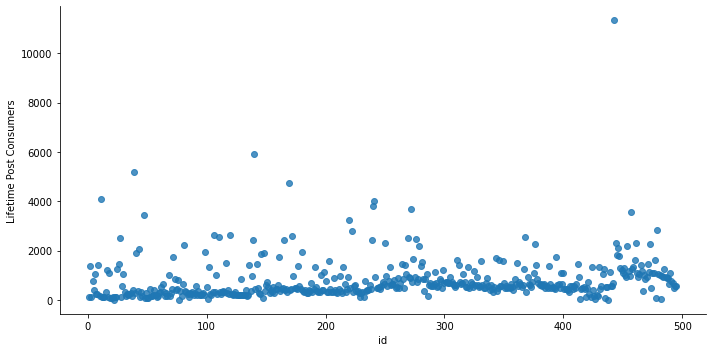

In [20]:
sns_plot = sns.lmplot(x="id", y="Lifetime Post Consumers", data=y_df, fit_reg=False, aspect = 2)

# sns_plot.savefig("scaterplot_lpc.png",bbox_inches='tight')
# sns_plot.savefig("scaterplot_lpc.pdf",bbox_inches='tight')

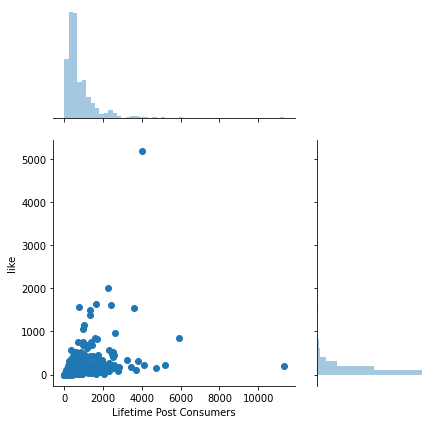

In [21]:
sns_plot = sns.jointplot(x="Lifetime Post Consumers", y="like", data=y_df, ratio = 2)

# sns_plot.savefig("joint_plot.png",bbox_inches='tight')
# sns_plot.savefig("joint_plot.pdf",bbox_inches='tight')

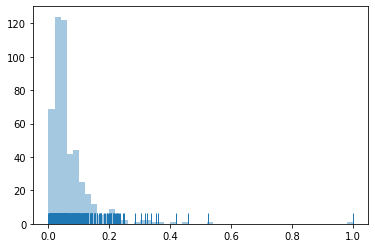

In [22]:
sns_plot = sns.distplot(y, kde=False, rug=True)

# sns_plot.savefig("histogram_lpc.png",bbox_inches='tight')
# sns_plot.savefig("histogram_lpc.pdf",bbox_inches='tight')

In [23]:
X = X_df.values
y = y_df.values.T[0]
y = (y - y.min())/(y.max() - y.min())

clf = DecisionTreeRegressor()
clf.fit(X, y)

print("MSE = ", mse(y, clf.predict(X)))

MSE =  1.5083953561640857e-05


In [0]:
n_test = 100
n_repeat = 1000

estimator = DecisionTreeRegressor()
#estimator = RandomForestRegressor()

# Compute predictions
y_predicts = np.zeros((n_repeat, len(X)))

for i in range(n_repeat):
    sample  = np.random.choice(range(len(X)),replace=True, size=len(X))
    train_ids = sample[:-n_test]
    test_ids  = sample[-n_test:]
    test_ids = np.setdiff1d(test_ids, train_ids)
    if(len(test_ids) == 0 ):
        continue

    X_train,y_train = X[train_ids], y[train_ids]
    X_test, y_test = X[test_ids], y[test_ids]
    
    estimator.fit(X_train, y_train)
    y_predict = estimator.predict(X_test)
    y_predicts[i,test_ids] = y_predict

In [26]:

y_bias = (y - np.mean(y_predicts, axis=0))**2
y_error = ((y - y_predicts) **2).mean()
y_var = np.var(y_predicts, axis=0, ddof = 1)


print(np.mean(y_bias) +  np.mean(y_var))

clf_type = "Decision tree"
print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          "+ {3:.4f} (var)".format(clf_type, np.mean(y_error), np.mean(y_bias), np.mean(y_var)))

print("{0}: {1:.4f} ((bias^2) + (var)) = {2:.4f} (bias^2) "
          "+ {3:.4f} (var)".format(clf_type, np.mean(y_bias) + np.mean(y_var), np.mean(y_bias), np.mean(y_var)))

0.010960203815820087
Decision tree: 0.0110 (error) = 0.0099 (bias^2) + 0.0010 (var)
Decision tree: 0.0110 ((bias^2) + (var)) = 0.0099 (bias^2) + 0.0010 (var)


In [0]:
#clf = RandomForestRegressor(n_estimators=1000,max_depth=2)
clf = BayesianRidge(normalize=True)

dummy_clf = DummyRegressor(strategy='mean')
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(mse))
dummy_scores = cross_val_score(dummy_clf, X, y, cv=10, scoring = make_scorer(mse))

print("MSE: %0.8f +/- %0.8f" % (scores.mean(), scores.std()))
print("Dummy MSE: %0.8f +/- %0.8f" % (dummy_scores.mean(), dummy_scores.std()))

#print clf

In [0]:
#Load the data from bank-additional-full.csv
#Use a classifier (anything, but ExtraTreesClassifier with 100 estimators is the easiest option) on the data with outcome/output variable "y"
#Convert to dummies using df_dummies = pd.get_dummies(df)
#Columns "y_no" and "duration" must be deleted - use something like del df_copy["attribute"] for this
#Plot histogram of the label y_yes
#Get the values and run a classifier (with outcome y_yes)
#Report the results of 10-Kfold stratified cross-validation
#Get sample importances and a confusion matrix

In [30]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4/bank-additional-full.csv", delimiter = ";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [31]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [32]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

       age  campaign  ...  poutcome_nonexistent  poutcome_success
0       56         1  ...                     1                 0
1       57         1  ...                     1                 0
2       37         1  ...                     1                 0
3       40         1  ...                     1                 0
4       56         1  ...                     1                 0
...    ...       ...  ...                   ...               ...
41183   73         1  ...                     1                 0
41184   46         1  ...                     1                 0
41185   56         2  ...                     1                 0
41186   44         1  ...                     1                 0
41187   74         3  ...                     0                 0

[41188 rows x 62 columns]
ACC: 0.53 +/- 0.25
Dummy ACC: 0.80


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


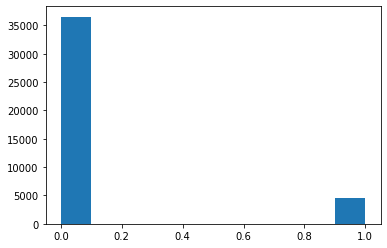

In [33]:

X = df.iloc[:, 0:19]
#print(X)
Y = df['y']
#print(Y)

from sklearn.preprocessing import LabelEncoder
df_dummies = pd.get_dummies(df)
plt.hist(df_dummies['y_yes'])

del df_dummies["duration"]
del df_dummies["y_no"]
Y = df_dummies['y_yes']
del df_dummies["y_yes"]
print(df_dummies)

model = ExtraTreesClassifier(n_estimators=100, random_state=0)
model.fit(df_dummies, Y)

dummy_clf = DummyClassifier()
scores = cross_val_score(model, df_dummies, Y, cv=10,scoring = make_scorer(acc))

dummy_clf.fit(df_dummies,Y)

print("ACC: %0.2f +/- %0.2f" % (scores.mean(), scores.std()))
print("Dummy ACC: %0.2f"% (acc(Y,dummy_clf.predict(df_dummies))))

Normalized confusion matrix


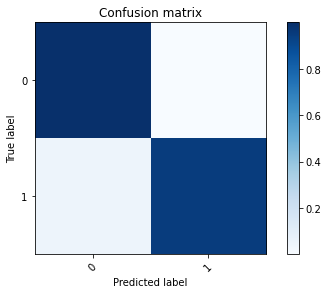

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        t = "(%.2f)"%(cm[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
import itertools

from sklearn.metrics import make_scorer, confusion_matrix

y_pred = model.predict(df_dummies)
cnf_matrix = confusion_matrix(Y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(len(set(Y))), normalize = True,
                      title='Confusion matrix')